TO DO: Explain the model using Latex, justify decisions, tidy up code by adding docstrings and comments

# Bayesian logistic regression

In [12]:
# Imports and seed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             roc_curve,
                             roc_auc_score,
                             ConfusionMatrixDisplay)

seed = 21

## Data

In [2]:
X, y = fetch_openml("diabetes", version=1, as_frame=True, return_X_y=True)
X.insert(0, 'const', 1)
cols = X.columns

display(X.describe())

,const,preg,plas,pres,skin,insu,mass,pedi,age
count,768.0,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,1.0,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,0.0,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.0,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,1.0,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,1.0,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,1.0,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [3]:
y = pd.DataFrame(y.map({'tested_negative': 0,
           'tested_positive': 1})).astype(int)
display(y.describe())

,class
count,768.000000
mean,0.348958
std,0.476951
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [4]:
X_np = X.to_numpy()
y_np = y.to_numpy().ravel()

X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X_np, y_np,
                                                    test_size = 0.25,
                                                    random_state=seed)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

## Bayesian logistic regression

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def intercept_mean(y):
    p0 = y.mean()
    intcpt_mean = np.log(p0/(1-p0))
    return intcpt_mean

def autocorr(x, lag):
    # Compute autocorrelation at a specific lag
    n = len(x)
    x_mean = np.mean(x)
    c0 = np.sum((x - x_mean) ** 2) / n
    c_lag = np.sum((x[:n - lag] - x_mean) * (x[lag:] - x_mean)) / (n - lag)
    return c_lag / c0

def log_posterior(beta, X, y, log_prior,
                  prior_int_var,
                  prior_coef_var):
    # Only up to a normalising constant
    # Prior also only up to a normalising constant
    def log_likelihood(beta, X, y):
        eta = X @ beta
        return np.sum(y * eta - np.log1p(np.exp(eta)))

    
    return log_likelihood(beta, X, y) + log_prior(beta, X, y,
                                                  prior_int_var,
                                                  prior_coef_var)

def log_weak_prior(beta, X, y, int_var,
                   coef_var):
    # Up to a normalising constant
    
    intcpt_mean = intercept_mean(y)
    
    int_prior = -((beta[0]-intcpt_mean)**2) / (2 * int_var)
    coef_prior = -0.5 * np.sum(beta[1:]**2 / coef_var)
    
    return int_prior + coef_prior

def rw_metro_hast(X, y, log_prior, proposal, nsamples,
                  prior_int_var, prior_coef_var,
                  proposal_var):
    chain = np.zeros((nsamples, X.shape[1]))
    chain[0] = np.zeros(X.shape[1])
    chain[0, 0] = intercept_mean(y)
    
    f = lambda x : log_posterior(x, X, y, log_prior,
                                 prior_int_var,
                                 prior_coef_var)
    accepted = 0
    for i in range(1, nsamples):
        move_proposal = chain[i-1] + proposal(X.shape[1],
                                              np.sqrt(proposal_var))
        
        log_ratio = f(move_proposal) - f(chain[i-1])
        
        if np.log(np.random.rand()) <= log_ratio:
            chain[i] = move_proposal
            accepted += 1
        else:
            chain[i] = chain[i-1]
        
    return chain, accepted / (nsamples - 1)
    
def normal_proposal(d, sd):
    return np.random.normal(scale = sd, size = d)

class BayesianLogRegression:
    def __init__(self, X, y, columns,
                 prior_int_var,
                 prior_coef_var,
                 proposal_var):
        self.scaler = StandardScaler()
        self.X = X
        self.y = y
        self.cols = columns
        self.prior_int_var = prior_int_var
        self.prior_coef_var = prior_coef_var
        self.proposal_var = proposal_var
        
        self.beta = None
    
    def simulate(self, log_prior, proposal, nsamples=10000):
        self.beta, accept_rate = rw_metro_hast(self.X,
                                               self.y,
                                               log_prior,
                                               proposal,
                                               nsamples,
                                               self.prior_int_var,
                                               self.prior_coef_var,
                                               self.proposal_var)
        print(f"MCMC simulation of posterior complete\nAcceptance rate: {accept_rate}")
        return
    
    def traceplot(self):
        if self.beta is None:
            raise ValueError("No posterior samples found. Run .simulate() first.")
            
        n = self.beta.shape[1]
        fig, axes = plt.subplots(n, 1, figsize=(8, 2.5 * n), sharex=True)
        
        for i, ax in enumerate(axes):
            ax.plot(self.beta[:, i])
            ax.set_title(f"Traceplot for parameter {self.cols[i]}")
            ax.set_ylabel("Value")
        
        axes[-1].set_xlabel("Iteration")
        plt.tight_layout()
        plt.show()
        
    def burn_in(self, T0):
        if self.beta is None:
            raise ValueError("No posterior samples found. Run .simulate() first.")
        
        self.beta = self.beta[T0:]
    
    def ESS(self, max_lag=None):
        if self.beta is None:
            raise ValueError("No posterior samples found. Run .simulate() first.")
        
        n, d = self.beta.shape
        
        if max_lag is None:
            max_lag = min(1000, n - 1)
        
        ess_dict = {}

        for i in range(d):
            chain = self.beta[:, i]
            # Centered chain
            chain = chain - np.mean(chain)
            var_chain = np.var(chain)
            
            rho_sum = 0
            for lag in range(1, max_lag):
                rho = autocorr(chain, lag)
                if rho <= 0:
                    break
                rho_sum += rho
            
            ess = n / (1 + 2 * rho_sum)
            ess_dict[self.cols[i]] = ess

        ess_df = pd.DataFrame.from_dict(ess_dict, orient='index', columns=['ESS'])
        ess_df['ESS_%_of_chain'] = 100 * ess_df['ESS'] / n  # ESS as % of chain length
        ess_df.index.name = 'Parameter'
        return ess_df
    
    def predict_prob(self, X):
        if self.beta is None:
            raise ValueError("No posterior samples found. Run .simulate() first.")
        
        eta = X @ self.beta.T # n_obs by chain length
        probs = sigmoid(eta) # distribution of preds for each observation
        return probs
    
    def accuracy(self, X_new, y_new):
        probs = self.predict_prob(X_new)
        med_probs = np.median(probs, axis=1)
        preds = np.heaviside(med_probs-0.5, 0).astype(int)
        acc = accuracy_score(y_new, preds)
        return acc
    
    def predict_proba(self, X_new, y_new):
        probs = self.predict_prob(X_new)
        med_probs = np.median(probs, axis=1)
        return med_probs
    
    def plot_cm(self, X_new, y_new):
        probs = self.predict_prob(X_new)
        med_probs = np.median(probs, axis=1)
        preds = np.heaviside(med_probs-0.5, 0).astype(int)
        
        cm = confusion_matrix(y_new, preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title("Bayesian logistic regression confusion matrix")
        plt.show()
    
    def forecast(self, X_new, y_new=None, alpha=0.025):
        
        if alpha > 0.5:
            return 1 - alpha
        
        probs = self.predict_prob(X_new)
        med_probs = np.median(probs, axis = 1)
        preds = np.heaviside(med_probs-0.5, 0).astype(int)
        lower_q = np.quantile(probs, alpha, axis = 1)
        upper_q = np.quantile(probs, 1-alpha, axis = 1)
        
        if y_new is None:
            return pd.DataFrame({'Forecast': preds,
                                 'Probability': med_probs,
                                 f'{alpha} percentile': lower_q,
                                 f'{1-alpha} percentile': upper_q})
        else:
            return pd.DataFrame({'Forecast': preds,
                                 'True value': y_new,
                                 'Probability': med_probs,
                                 f'{alpha} percentile': lower_q,
                                 f'{1-alpha} percentile': upper_q})

MCMC simulation of posterior complete
Acceptance rate: 0.2613926139261393


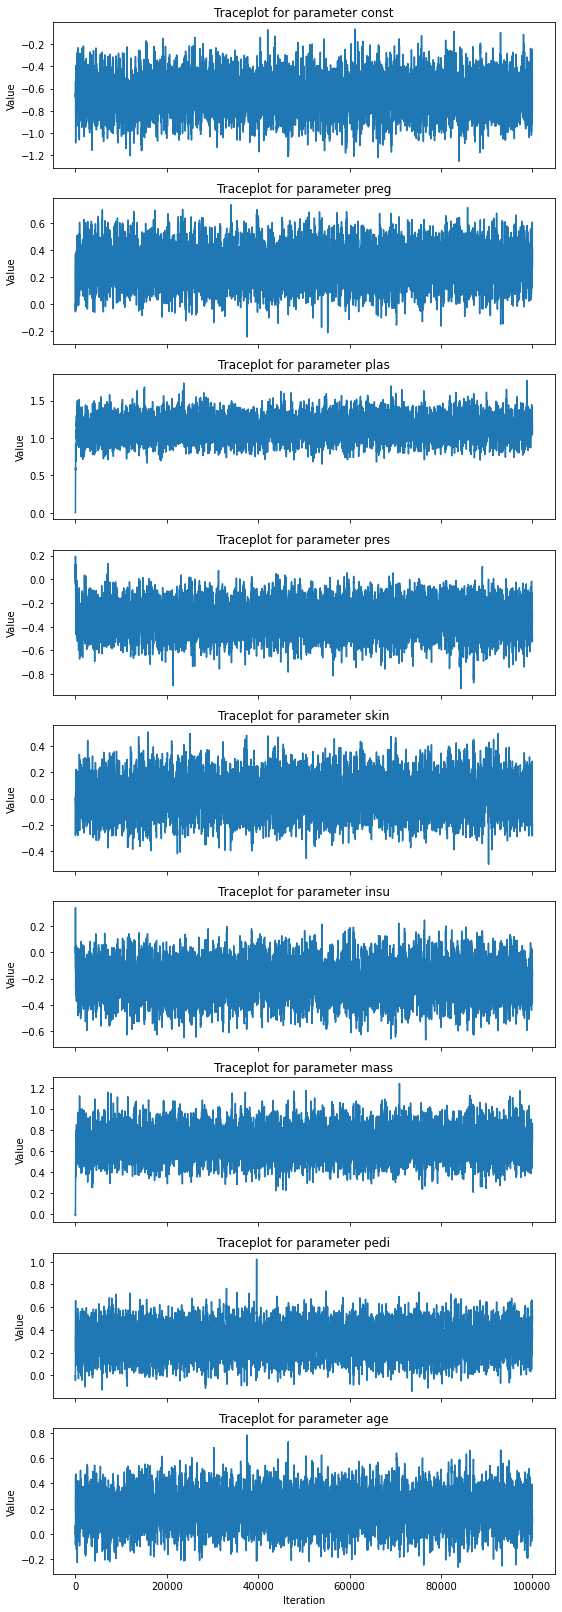

In [6]:
blr = BayesianLogRegression(X_train, y_train, cols,
                            0.0235, 1, 0.008)
blr.simulate(log_weak_prior, normal_proposal, 100000)
blr.traceplot()

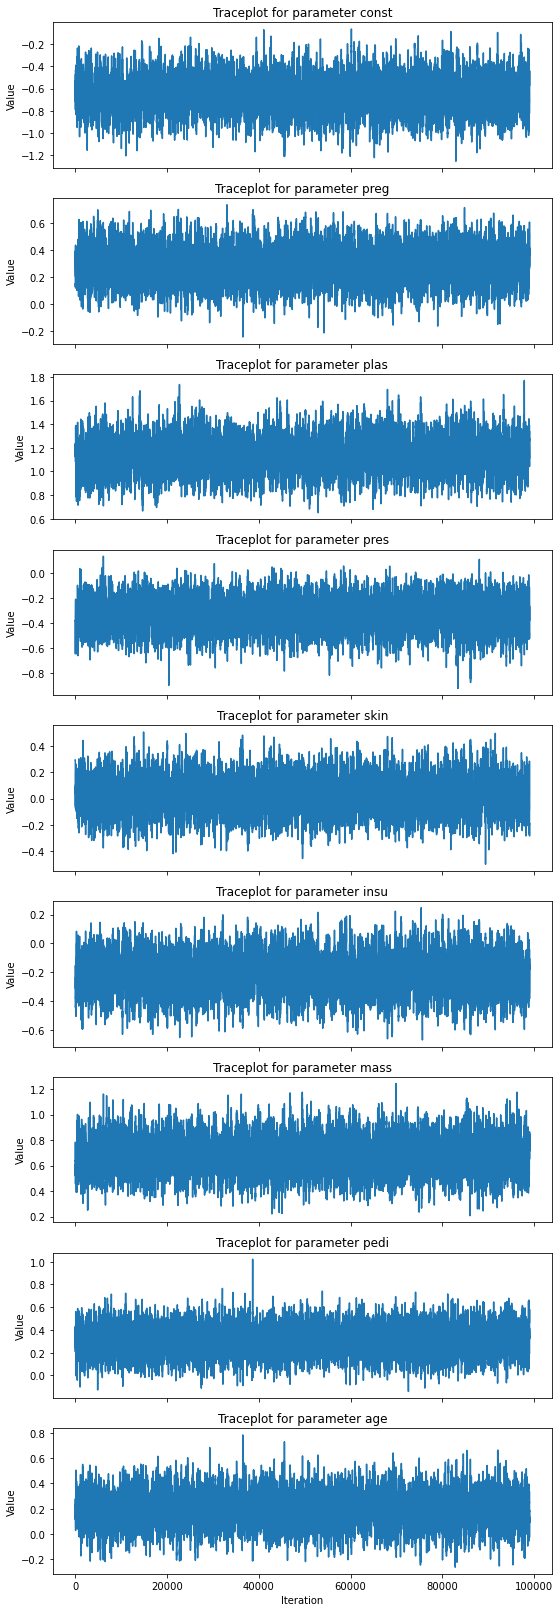

,ESS,ESS_%_of_chain
Parameter,,
const,2082.657882,2.103695
preg,2352.099316,2.375858
plas,1577.897359,1.593836
pres,2664.150979,2.691062
skin,2265.624124,2.288509
insu,1678.362157,1.695315
mass,2433.593122,2.458175
pedi,3330.349116,3.363989
age,2177.967152,2.199967


In [7]:
blr.burn_in(1000)
blr.traceplot()
display(blr.ESS())

Accuracy of Bayesian model on training data: 0.7552083333333334


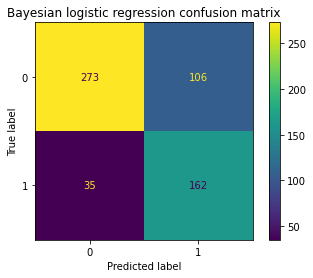

,Forecast,True value,Probability,0.025 percentile,0.975 percentile
0,0,0,0.336774,0.249236,0.433780
1,0,0,0.424410,0.352532,0.496406
2,1,1,0.734511,0.646852,0.811789
3,1,1,0.547981,0.435922,0.657008
4,0,0,0.184185,0.138980,0.235783
...,...,...,...,...,...
571,0,1,0.359070,0.284794,0.437189
572,1,1,0.949873,0.891941,0.978779
573,0,0,0.076697,0.045517,0.120225
574,1,1,0.572442,0.468553,0.671149


In [8]:
print(f'Accuracy of Bayesian model on training data: {blr.accuracy(blr.X, blr.y)}')
blr.plot_cm(blr.X, blr.y)
display(blr.forecast(blr.X, blr.y))

## Fitting logistic regression with MLE

Accuracy of MLE model on training data: 0.7881944444444444


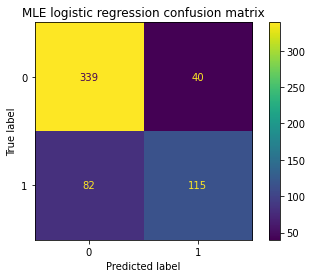

In [9]:
mlelr = LogisticRegression(penalty='none')
mlelr.fit(X_train, y_train)

mle_train_preds = mlelr.predict(X_train)
mle_train_acc = accuracy_score(y_train, mle_train_preds)
print(f'Accuracy of MLE model on training data: {mle_train_acc}')

mle_train_cm = confusion_matrix(y_train, mle_train_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=mle_train_cm)
disp.plot()
plt.title("MLE logistic regression confusion matrix")
plt.show()

## Comparison

Accuracy of Bayesian model on test data: 0.734375
Accuracy of MLE model on test data: 0.7881944444444444


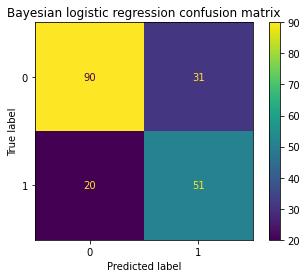

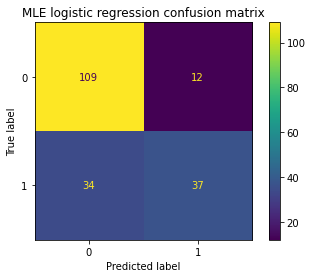

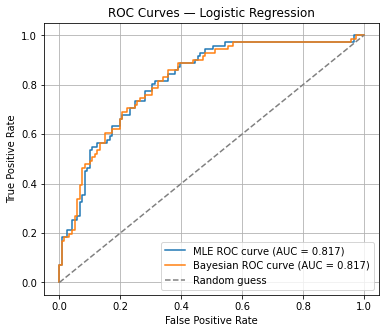

In [10]:
# Accuracy:
print(f'Accuracy of Bayesian model on test data: {blr.accuracy(X_test, y_test)}')

mle_test_preds = mlelr.predict(X_test)
mle_test_acc = accuracy_score(y_test, mle_test_preds)
print(f'Accuracy of MLE model on test data: {mle_train_acc}')



# Confusion matrix
blr.plot_cm(X_test, y_test)

mle_test_cm = confusion_matrix(y_test, mle_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=mle_test_cm)
disp.plot()
plt.title("MLE logistic regression confusion matrix")
plt.show()



# ROC curve
mle_probs = mlelr.predict_proba(X_test)[:, 1]
blr_probs = blr.predict_proba(X_test, y_test)

m_fpr, m_tpr, m_thresholds = roc_curve(y_test, mle_probs)
m_auc = roc_auc_score(y_test, mle_probs)

b_fpr, b_tpr, b_thresholds = roc_curve(y_test, blr_probs)
b_auc = roc_auc_score(y_test, blr_probs)

plt.figure(figsize=(6, 5))
plt.plot(m_fpr, m_tpr, label=f'MLE ROC curve (AUC = {m_auc:.3f})')
plt.plot(b_fpr, b_tpr, label=f'Bayesian ROC curve (AUC = {b_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves — Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
blr.forecast(X_test, y_test)

,Forecast,True value,Probability,0.025 percentile,0.975 percentile
0,1,1,0.520644,0.365226,0.672596
1,0,0,0.216270,0.136024,0.318927
2,0,0,0.204497,0.131514,0.298988
3,1,1,0.789669,0.711488,0.853711
4,1,1,0.723266,0.601464,0.822450
...,...,...,...,...,...
187,1,1,0.681880,0.509356,0.814307
188,0,0,0.382864,0.258666,0.524578
189,1,1,0.808023,0.690770,0.892058
190,0,0,0.064329,0.038642,0.100614
